In [29]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

In [7]:
df_tweets = pd.read_csv('data/tweets_no_dupl.csv', sep='#')
df_users = pd.read_csv('data/users_clean.csv', sep='#')

# Tweets csv cleaning

## id
In the id column there are only two missing values. Since the column is not meaningful for the analysis phase, the column is dropped.

## user_id
In the user_id column there are a lot of missing values, wrong values (non numerical ids) and 210778 user ids do not have any correspondance with users file. Nevertheless, these records have been kept because the other columns could be useful for future analyses.

## retweet_count


In [10]:
df_tweets.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 10 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   id              11712346 non-null  object
 1   user_id         11495314 non-null  object
 2   retweet_count   11275326 non-null  object
 3   reply_count     11064671 non-null  object
 4   favorite_count  11064981 non-null  object
 5   num_hashtags    10655073 non-null  object
 6   num_urls        11063920 non-null  object
 7   num_mentions    10858432 non-null  object
 8   created_at      11712348 non-null  object
 9   text            11182415 non-null  object
dtypes: object(10)
memory usage: 893.6+ MB


In [11]:
df_tweets.drop(columns=['id'], inplace=True)

Select records which have both user_id and text values which are null

In [12]:
df_tweets[np.logical_and(df_tweets['user_id'].isnull(), df_tweets['text'].isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56118 entries, 42 to 11712030
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         0 non-null      object
 1   retweet_count   51567 non-null  object
 2   reply_count     25737 non-null  object
 3   favorite_count  50960 non-null  object
 4   num_hashtags    392 non-null    object
 5   num_urls        26107 non-null  object
 6   num_mentions    466 non-null    object
 7   created_at      56118 non-null  object
 8   text            0 non-null      object
dtypes: object(9)
memory usage: 4.3+ MB


Merge users table with tweets table by user_id

In [14]:
df_users.id = df_users.id.astype(str)
merged = df_tweets.merge(df_users, left_on='user_id', right_on='id', how='left')


In [15]:
df_tweets.shape

(11712348, 9)

In [16]:
merged.shape

(11712348, 16)

Number of `user_id` that have no correspondance in users file.

In [17]:
len(merged[merged['id'].isnull()].user_id.unique())

210778

## Clean retweet_counts column

Cast retweet_count values in a new column to float (there are number to big for int) and set to -1.0 when there is a value which is not a number or an uncastable value (e.g. string)

In [18]:
def to_float(x):
    try:
        x=float(x)
        if(np.isnan(x)):
            return float(-1)
        else:
            return x
    except:
        return float(-1)

Plot an histogram w.r.t. a single attribute passed as parameter.

In [19]:
def plot_hist_log(dataframe, attribute_name):
    attr_log = pd.DataFrame()
    attr_log[attribute_name + '_log'] = np.log(dataframe[attribute_name].values)
    attr_log[attribute_name + '_log'] = attr_log[attribute_name + '_log'].replace(-np.inf, 0)

    n_bins = math.ceil(np.log2(len(attr_log[attribute_name + '_log'])) + 1) #Sturges' rule
    attr_log.hist(attribute_name + '_log', bins = n_bins, log=True)

In [20]:
df_tweets['retweet_count_conv'] = df_tweets.retweet_count.apply(to_float)

In [21]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   retweet_count       object 
 2   reply_count         object 
 3   favorite_count      object 
 4   num_hashtags        object 
 5   num_urls            object 
 6   num_mentions        object 
 7   created_at          object 
 8   text                object 
 9   retweet_count_conv  float64
dtypes: float64(1), object(9)
memory usage: 893.6+ MB


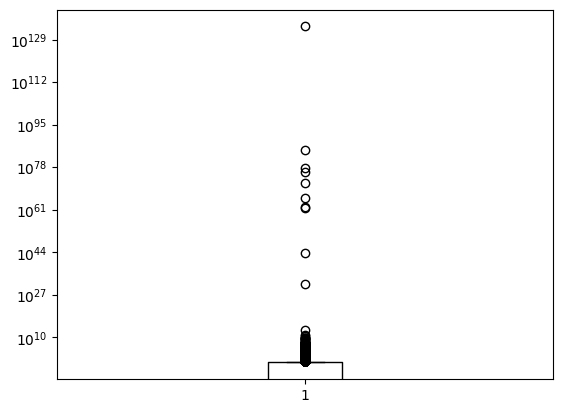

In [23]:
plt.boxplot(df_tweets[df_tweets['retweet_count_conv'] != -1.0].retweet_count_conv,showmeans=True)
plt.yscale('log')
plt.show()

We have noticed a lot of huge values in the `retweet_count_conv` **(RCC)** column. By analysing statistics of real tweets on the web, we have decide to perform further analysis on records having a RCC value lower than 1e7 (https://en.wikipedia.org/wiki/List_of_most-retweeted_tweets)

In [25]:
droppe = df_tweets[np.logical_and(df_tweets['retweet_count_conv'] != -1.0, df_tweets['retweet_count_conv'] < 1e7)]

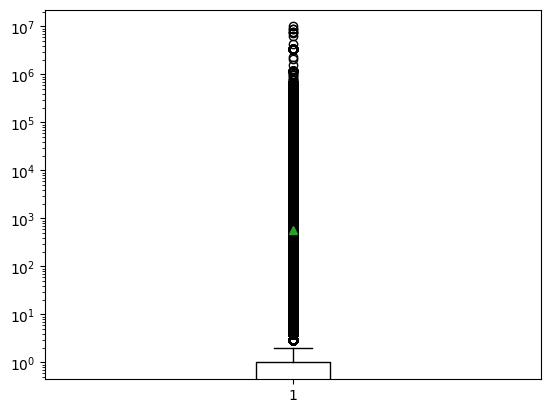

In [26]:
plt.boxplot(droppe.retweet_count_conv,showmeans=True)
plt.yscale('log')
plt.show()

The boxplot is not informative, so we investigate this field by means of an histogram.

C:\Users\Alessandro\AppData\Local\Temp\ipykernel_23388\2640229493.py:3: RuntimeWarning: divide by zero encountered in log
  attr_log[attribute_name + '_log'] = np.log(dataframe[attribute_name].values)


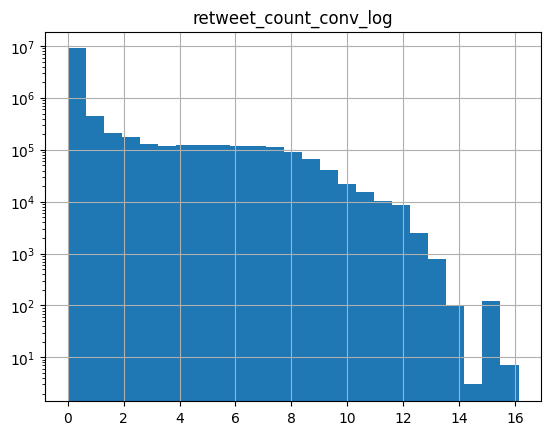

In [30]:
plot_hist_log(droppe, 'retweet_count_conv')

In [31]:
rtc_mean = np.mean(droppe.retweet_count_conv.values)
rtc_median = np.median(droppe.retweet_count_conv.values)
print("mean: " + str(rtc_mean))
print("median: " + str(rtc_median))

mean: 580.7886859027697
median: 0.0


As it is possible to see the distribution is positively skewed. Considering the statistical indicators, it is clear that the mean is too much influenced by outliers so the median has been taken in account.

In [32]:
df_tweets['retweet_count_replaced'] = df_tweets['retweet_count_conv'].replace({-1.0: rtc_median})
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11712348 entries, 0 to 11712347
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   user_id                 object 
 1   retweet_count           object 
 2   reply_count             object 
 3   favorite_count          object 
 4   num_hashtags            object 
 5   num_urls                object 
 6   num_mentions            object 
 7   created_at              object 
 8   text                    object 
 9   retweet_count_conv      float64
 10  retweet_count_replaced  float64
dtypes: float64(2), object(9)
memory usage: 982.9+ MB


In [34]:
df_tweets.drop(columns = ['retweet_count_conv'], inplace=True)

In [39]:
merged = df_tweets[df_tweets['retweet_count_replaced'] > 1e10].merge(df_users, left_on='user_id', right_on='id', how='left')
merged[['user_id', 'retweet_count_replaced', 'reply_count', 'favorite_count', 'bot', 'created_at_x', 'created_at_y', 'text', 'statuses_count']]

,user_id,retweet_count_replaced,reply_count,favorite_count,bot,created_at_x,created_at_y,text,statuses_count
0,910519015,9.060000e+61,0.0,NaN,0.0,2019-03-30 22:05:10,2017-10-30 15:19:12,"Giant Fremontadendron califirnica, Flannel Bus...",1952.0
1,2374871490,2.000000e+134,0.0,0.0,1.0,2019-07-06 10:54:48,2019-03-08 05:36:34,NaN,44.0
2,376588311,8.600000e+43,m44g,2.0,0.0,2019-08-01 10:21:16,2016-09-21 04:30:51,SAKE BOMB,2203.0
3,225618739,1.000000e+76,0.0,NaN,0.0,2020-01-19 06:49:11,2015-12-14 01:21:28,@kylokrel not if ur me,8643.0
4,465392182,7.000000e+84,0.0,0.0,1.0,2019-11-03 22:29:44,2017-01-17 09:08:19,La mamma Ã¨ quella che ti insegna a pregare--P...,78.0
5,183247631,3.400000e+31,0.0,0.0,0.0,2020-01-16 16:36:11,2015-08-28 14:50:22,I could keep babbling but I'm pretty sure I ra...,7089.0
6,521358579,inf,NaN,0.0,1.0,2019-10-05 03:46:47,2017-03-13 14:18:57,NaN,11462.0
7,274285556,6.500000e+10,0.0,0.0,0.0,2019-05-15 03:52:11,2016-03-31 02:24:19,@LeviGatorfan is my #mcm. He makes every day s...,4477.0
8,251633570,6.000000e+77,0.0,0.0,0.0,2020-04-07 06:38:50,2016-02-15 14:59:58,RT @AlexDijkstra_: @tapijtlegger @MDMAbleToShi...,67875.0
9,294996484,7.000000e+61,0.0,0.0,0.0,2020-03-20 02:55:50,2016-05-09 05:17:53,NaN,3233.0


In [40]:
df_tweets.drop(columns=['retweet_count'], inplace=True)

In [40]:
#TODO cast float to int of retweet_count

Now we have `retweet_count_replaced` with all numeric values. We have many values that seems to be "noise" but before replacing them we want to explore the correlation with other attributes related to the tweet popularity which are  `reply_count` and `favourite_count`. So this task is postponed. Instead for the missing values (-1) we have checked if the same user has other tweets in the dataset to extract statistics from them. If there are not other tweets or there are only tweets with missing values the median is set as default.
# TODO mettere insieme il casting e la conversione dopo

# Clean reply_count column

In [42]:
df_tweets['reply_count_conv'] = df_tweets.reply_count.apply(to_float)

In [43]:
mean_reply_count = df_tweets.reply_count_conv.mean()
median_reply_count = df_tweets.reply_count_conv.median()
print("mean: " + str(mean_reply_count))
print("median: " + str(median_reply_count))

mean: inf
median: 0.0


In [45]:
mean_reply_count = df_tweets[df_tweets['reply_count_conv'] < 1e10].reply_count_conv.mean()
median_reply_count = df_tweets[df_tweets['reply_count_conv'] < 1e10].reply_count_conv.median()
print("mean: " + str(mean_reply_count))
print("median: " + str(median_reply_count))

mean: 4170.42772079839
median: 0.0


C:\Users\Alessandro\AppData\Local\Temp\ipykernel_23388\2640229493.py:3: RuntimeWarning: divide by zero encountered in log
  attr_log[attribute_name + '_log'] = np.log(dataframe[attribute_name].values)
C:\Users\Alessandro\AppData\Local\Temp\ipykernel_23388\2640229493.py:3: RuntimeWarning: invalid value encountered in log
  attr_log[attribute_name + '_log'] = np.log(dataframe[attribute_name].values)


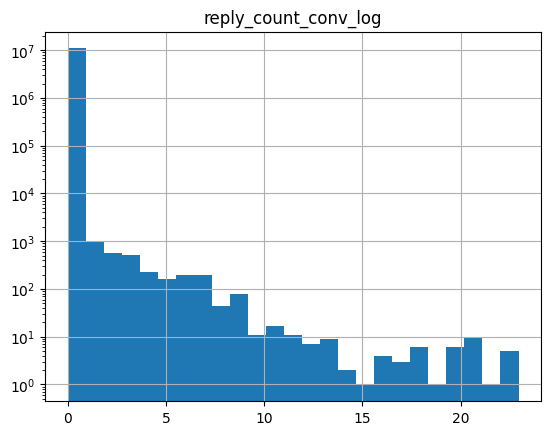

In [47]:
plot_hist_log(df_tweets[df_tweets['reply_count_conv'] < 1e10], 'reply_count_conv')

# Clean favourite_counts column

Check correlation between `retweet_counts`, `replay_counts` and `favourite_counts`

<AxesSubplot:>

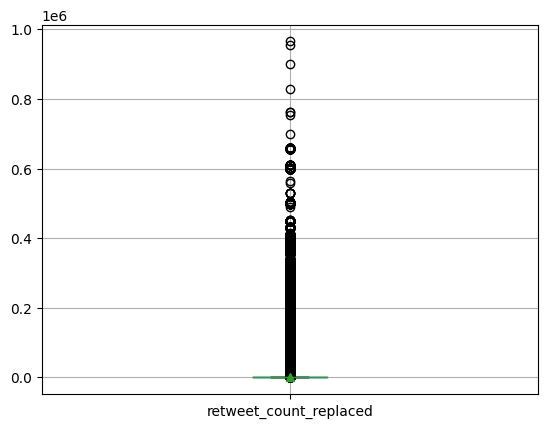

In [38]:
df_tweets[df_tweets['retweet_count_replaced'] < 1e6].boxplot('retweet_count_replaced', showmeans=True)